In [1]:
!pip install shap xgboost lightgbm

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

In [3]:
!wget -O cs-training.csv "https://raw.githubusercontent.com/JLZml/Credit-Scoring-Data-Sets/master/3.%20Kaggle/Give%20Me%20Some%20Credit/cs-training.csv"
!wget -O cs-test.csv "https://raw.githubusercontent.com/JLZml/Credit-Scoring-Data-Sets/master/3.%20Kaggle/Give%20Me%20Some%20Credit/cs-test.csv"

train = pd.read_csv("cs-training.csv", index_col=0)
test = pd.read_csv("cs-test.csv", index_col=0)

print("Train shape:", train.shape)
print("Test shape:", test.shape)
train.head()


--2025-08-28 06:47:27--  https://raw.githubusercontent.com/JLZml/Credit-Scoring-Data-Sets/master/3.%20Kaggle/Give%20Me%20Some%20Credit/cs-training.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7564965 (7.2M) [text/plain]
Saving to: ‘cs-training.csv’

cs-training.csv     100%[===================>]   7.21M  18.1MB/s    in 0.4s    

2025-08-28 06:47:28 (18.1 MB/s) - ‘cs-training.csv’ saved [7564965/7564965]

--2025-08-28 06:47:28--  https://raw.githubusercontent.com/JLZml/Credit-Scoring-Data-Sets/master/3.%20Kaggle/Give%20Me%20Some%20Credit/cs-test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [4]:
print(train.isnull().sum())

train = train.fillna(train.median())
test = test.fillna(train.median())
target = "SeriousDlqin2yrs"


SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64


In [5]:
X = train.drop(columns=[target])
y = train[target]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)

Train: (120000, 10) (120000,)
Validation: (30000, 10) (30000,)


In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(test.drop(columns=[target], errors="ignore"))

print("Scaling done.")

Scaling done.


In [7]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_scaled, y_train)

y_val_pred = lr.predict(X_val_scaled)
y_val_proba = lr.predict_proba(X_val_scaled)[:,1]

print("Logistic Regression Results:")
print(classification_report(y_val, y_val_pred))
print("ROC-AUC:", roc_auc_score(y_val, y_val_proba))

Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     27995
           1       0.58      0.04      0.08      2005

    accuracy                           0.93     30000
   macro avg       0.76      0.52      0.52     30000
weighted avg       0.91      0.93      0.91     30000

ROC-AUC: 0.7143274515978317


In [8]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

y_val_pred = rf.predict(X_val)
y_val_proba = rf.predict_proba(X_val)[:,1]

print("Random Forest Results:")
print(classification_report(y_val, y_val_pred))
print("ROC-AUC:", roc_auc_score(y_val, y_val_proba))


Random Forest Results:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     27995
           1       0.56      0.19      0.28      2005

    accuracy                           0.94     30000
   macro avg       0.75      0.59      0.62     30000
weighted avg       0.92      0.94      0.92     30000

ROC-AUC: 0.8472166164335544


In [9]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb_model.fit(X_train, y_train)

y_val_pred = xgb_model.predict(X_val)
y_val_proba = xgb_model.predict_proba(X_val)[:,1]

print("XGBoost Results:")
print(classification_report(y_val, y_val_pred))
print("ROC-AUC:", roc_auc_score(y_val, y_val_proba))

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [06:51:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Results:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     27995
           1       0.56      0.21      0.31      2005

    accuracy                           0.94     30000
   macro avg       0.75      0.60      0.64     30000
weighted avg       0.92      0.94      0.92     30000

ROC-AUC: 0.8600524051542869


In [10]:
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train, y_train)

y_val_pred = lgb_model.predict(X_val)
y_val_proba = lgb_model.predict_proba(X_val)[:,1]

print("LightGBM Results:")
print(classification_report(y_val, y_val_pred))
print("ROC-AUC:", roc_auc_score(y_val, y_val_proba))

[LightGBM] [Info] Number of positive: 8021, number of negative: 111979
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028861 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 975
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.066842 -> initscore=-2.636248
[LightGBM] [Info] Start training from score -2.636248
LightGBM Results:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     27995
           1       0.60      0.19      0.28      2005

    accuracy                           0.94     30000
   macro avg       0.77      0.59      0.63     30000
weighted avg       0.92      0.94      0.92     30000

ROC-AUC: 0.8680765936560635


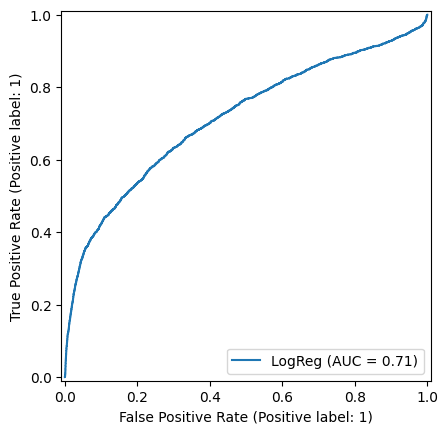

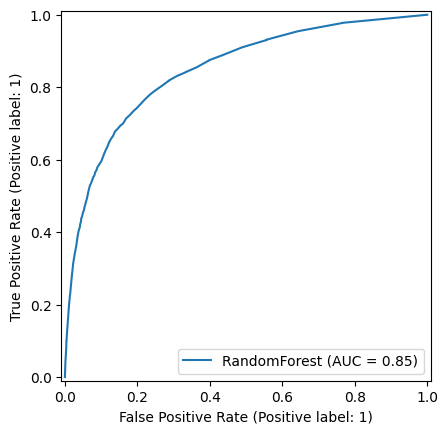

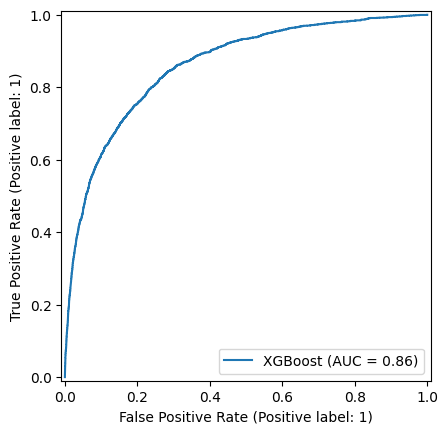

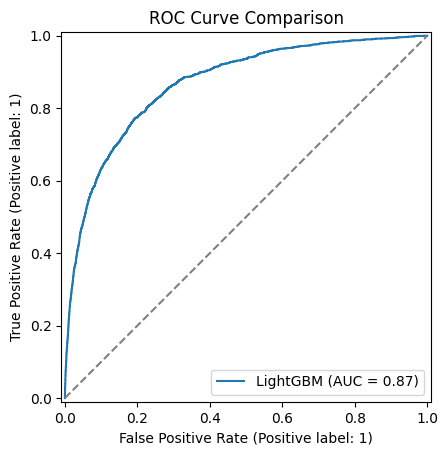

In [11]:
RocCurveDisplay.from_estimator(lr, X_val_scaled, y_val, name="LogReg")
RocCurveDisplay.from_estimator(rf, X_val, y_val, name="RandomForest")
RocCurveDisplay.from_estimator(xgb_model, X_val, y_val, name="XGBoost")
RocCurveDisplay.from_estimator(lgb_model, X_val, y_val, name="LightGBM")

plt.plot([0,1],[0,1],'--',color='gray')
plt.title("ROC Curve Comparison")
plt.show()

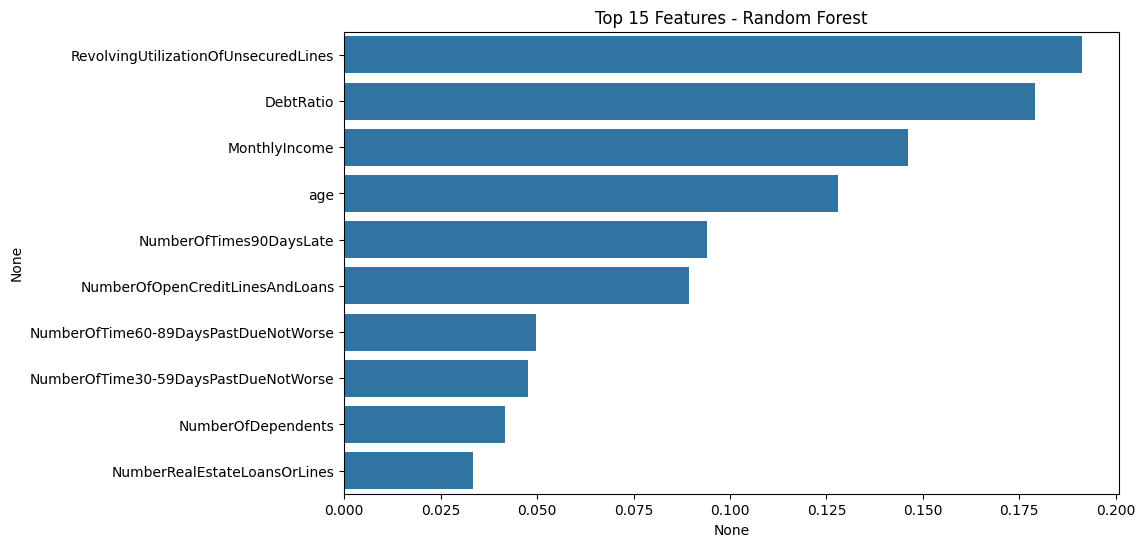

In [12]:
importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=importances[:15], y=importances.index[:15])
plt.title("Top 15 Features - Random Forest")
plt.show()

In [14]:
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_train.columns)

test["Predicted_Probability"] = lgb_model.predict_proba(X_test_scaled_df)[:,1]

# Save for Tableau
test.to_csv("credit_risk_predictions.csv", index=False)
print("Results saved: credit_risk_predictions.csv")


Results saved: credit_risk_predictions.csv
